This is a live notebook with experimental code to develop analysis investigating the correlation between features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json
import math

import scipy.stats
import seaborn as sns

import os


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from importlib import reload

from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import RESULTS_BASE_PATH
from predicament.utils.config import establish_path
from predicament.utils.file_utils import load_dataframe_and_config

from predicament.data.features import IDEAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import filter_features
from predicament.data.features import get_feature_group
from predicament.data.features import filter_and_group_feature_names
from predicament.data.features import derive_feature_types
from predicament.data.features import filter_and_group_featured_df
from predicament.data.features import robustify_feature_names
from predicament.data.features import replace_channel_ids_with_channel_names
from predicament.data.features import construct_feature_groups

from predicament.data.features import derive_feature_types
from predicament.analysis.correlations import scatter_plot_features
from predicament.analysis.correlations import get_feature_feature_correlations
from predicament.analysis.correlations import plot_feature_feature_correlations
from predicament.analysis.correlations import plot_density_of_correlated_features
from predicament.analysis.correlations import pval_from_pearsonsr
from predicament.analysis.correlations import analyse_feature_vs_comparator

from predicament.utils.dataframe_utils import compute_and_add_aggregating_column
from predicament.utils.dataframe_utils import aggregate_rows_by_grouped_index
from predicament.utils.dataframe_utils import split_column_into_independent_columns

## dreem (EEG) data or E4 data



In [5]:
# subdir = 'binary_E4_4secs'
# subdir = 'binary_E4_10secs'
# subdir = 'E4_4secs'
# subdir = 'E4_10secs'
subdir = 'dreem_4secs'
# subdir = 'binary_dreem_4secs'
# subdir = 'dreem_10secs'
# subdir = 'binary_dreem_10secs'
allow_unsafe_features = False
group_names = ['stats', 'info', 'freq']
allow_overlapping_windows = False
remove_overlapping_windows = not allow_overlapping_windows

featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featured_df, config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

In [6]:
n_channels = config['LOAD']['n_channels']
# data_format = config['LOAD']['data_format']
# print(f"data_format = {data_format}")
channels = config['LOAD']['channels']
print(f"channels = {channels}")
participant_list = config['LOAD']['participant_list']
Fs = config['LOAD']['sample_rate']
window_size = config['LOAD']['window_size']
window_step = config['LOAD']['window_step']
label_mapping = config['LOAD']['label_mapping']
label_cols = config['WINDOWED']['label_cols']
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")

channels = ['EEG Fpz-O1', 'EEG Fpz-O2', 'EEG Fpz-F7', 'EEG Fpz-F8']
Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 4


In [7]:
results_dir = establish_path(RESULTS_BASE_PATH, subdir)
print(f"results_dir  = {results_dir}")

results_dir  = ../data/results/dreem_4secs


In [8]:
# featured_df, feature_names = remove_features_with_inf_values(
featured_df, config, group_feature_mapping = filter_and_group_featured_df(
    featured_df, config, group_names,
    allow_unsafe_features, remove_overlapping_windows)
featured_df.shape

(3430, 81)

## Feature-comparator correlations

saving to ../data/results/dreem_4secs/feature_vs_condition_channel_correlations.csv
saving plot to ../data/results/dreem_4secs/feature_vs_condition_channel_correlations.png


/home/luke/git/external/predicament/predicament/analysis/correlations.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


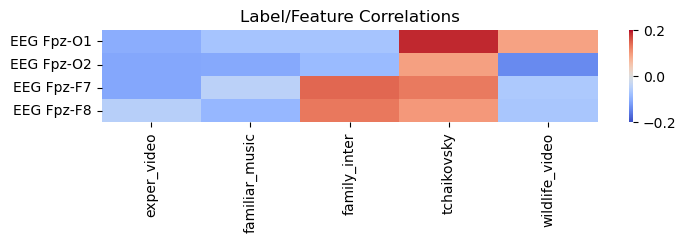

In [9]:
# analysis parameters
comparator = "condition"
group_by='channel'
add_agg_column = False
aggregate_rows = True
remove_rows_with_nans = False
row_agg_element='cell'
row_agg_mode = 'abs_max'
# plot parameters
# whether to give r value in cell
annot=False
row_height = 0.3
col_width = 0.3
granularity = 40

correlation_mtx = analyse_feature_vs_comparator(
    featured_df, config, results_dir, comparator, group_by,
    add_agg_column, aggregate_rows, remove_rows_with_nans,
    row_agg_element, row_agg_mode, 
    annot, row_height, col_width, granularity)

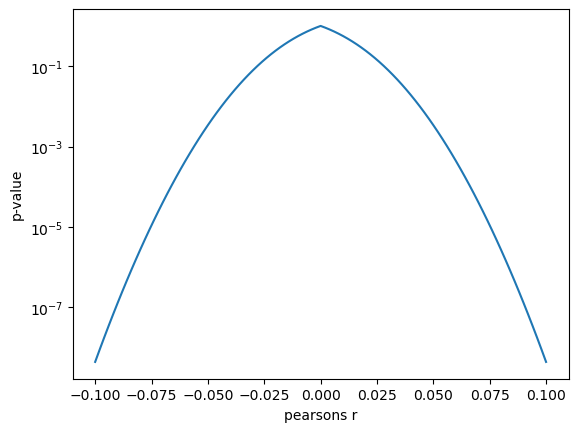

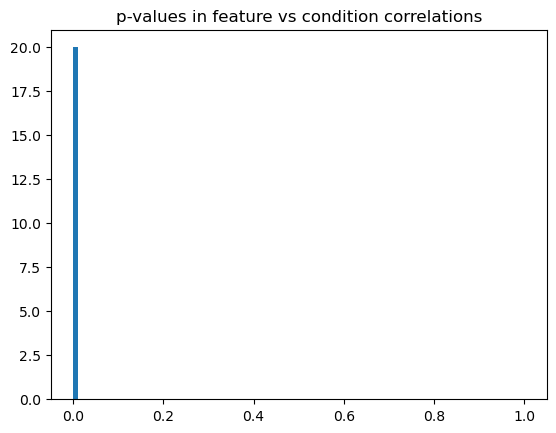

In [10]:
n = len(featured_df.index)


max_abs_val = np.nanmax(np.abs(correlation_mtx.values))
plt.figure()
rhos = np.linspace(-max_abs_val,max_abs_val,101)
rhos = np.linspace(-0.1,0.1,101)
pvals = pval_from_pearsonsr(rhos,n)
plt.plot(rhos, pvals)
plt.xlabel("pearsons r")
plt.ylabel("p-value")
plt.yscale('log')

plt.figure()
rhos = correlation_mtx.values
pvals = pval_from_pearsonsr(rhos,n)
plt.hist(pvals.flatten(), bins=np.linspace(0,1,101))
_ = plt.title("p-values in feature vs condition correlations")